In [80]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
#from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [81]:
housePrices=pd.read_csv("./data.csv").sample(frac=1)
# We will not process the ClosedDate column - so remove it
housePrices.pop('ClosedDate')
housePrices.head()

,SoldPr,Type,Zip,Area,Rooms,FullBaths,HalfBaths,BsmtBth,Beds,BsmtBeds,GarageSpaces,houseEra
8444,5.519064e+05,SFH,60062,2913,8,2,1,No,4.0,0,2.0,19A
552,3.090676e+05,SFH,60077,1091,7,1,1,Yes,3.0,0,2.0,19A
4553,1.365812e+06,SFH,60201,4777,15,3,2,Yes,7.0,0,2.0,19B
678,1.500103e+05,Condo,60025,900,5,1,0,No,2.0,0,0.0,19A
8486,3.895000e+05,SFH,60002,3474,11,2,2,Yes,3.0,0,3.0,19A


In [82]:
housePrices['Zip'] = housePrices['Zip'].astype(str) 
housePrices.dtypes

SoldPr          float64
Type             object
Zip              object
Area              int64
Rooms             int64
FullBaths         int64
HalfBaths         int64
BsmtBth          object
Beds            float64
BsmtBeds          int64
GarageSpaces    float64
houseEra         object
dtype: object

In [83]:
train, test = train_test_split(housePrices, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

5988 train examples
1498 validation examples
1872 test examples


In [84]:
housePrices_features = train.copy()
housePrices_labels = housePrices_features.pop('SoldPr')
housePrices_labels = housePrices_labels/100000

val_features = val.copy()
val_labels = val.pop('SoldPr')
val_labels = val_labels/100000

print(housePrices_features.dtypes)
print(housePrices_labels.dtypes)

Type             object
Zip              object
Area              int64
Rooms             int64
FullBaths         int64
HalfBaths         int64
BsmtBth          object
Beds            float64
BsmtBeds          int64
GarageSpaces    float64
houseEra         object
dtype: object
float64


In [85]:
inputs = {}

for name, column in housePrices_features.items():
  dtype = column.dtype
  if isinstance(dtype, object):
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'Type': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Type')>,
 'Zip': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Zip')>,
 'Area': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Area')>,
 'Rooms': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Rooms')>,
 'FullBaths': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'FullBaths')>,
 'HalfBaths': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'HalfBaths')>,
 'BsmtBth': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'BsmtBth')>,
 'Beds': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Beds')>,
 'BsmtBeds': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'BsmtBeds')>,
 'GarageSpaces': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'GarageSpaces')>,
 'houseEra': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'houseEra')>}

In [86]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(housePrices[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'normalization_6')>

In [87]:
preprocessed_inputs = [all_numeric_inputs]

In [88]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  
  lookup = preprocessing.StringLookup(vocabulary=np.unique(housePrices_features[name]))
  one_hot = preprocessing.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

In [89]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

housePrices_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = housePrices_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [90]:
housePrices_features_dict = {name: np.array(value) 
                         for name, value in housePrices_features.items()}

features_dict = {name:values[:1] for name, values in housePrices_features_dict.items()}
housePrices_preprocessing(features_dict)

<tf.Tensor: shape=(1, 39), dtype=float32, numpy=
array([[ 0.297,  0.001, -0.236,  0.767,  0.744, -0.374,  0.243,  0.   ,
         0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,
         0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]],
      dtype=float32)>

In [91]:
def housePrices_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(64,activation='relu'),
    #layers.Dense(64,activation='relu'),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model

housePrices_model = housePrices_model(housePrices_preprocessing, inputs)

In [92]:
val_features_dict = {name: np.array(value) 
                         for name, value in val.items()}
history_1 = housePrices_model.fit(x=housePrices_features_dict, y=housePrices_labels,epochs=250,
                        validation_data=(val_features_dict, val_labels))

Epoch 1/250
188/188 [==============================] - 1s 2ms/step - loss: 6.2528 - mae: 1.5289 - val_loss: 1.8587 - val_mae: 0.9001
Epoch 2/250
188/188 [==============================] - 0s 1ms/step - loss: 2.3309 - mae: 0.9083 - val_loss: 1.5334 - val_mae: 0.7915
Epoch 3/250
188/188 [==============================] - 0s 1ms/step - loss: 2.0870 - mae: 0.8624 - val_loss: 1.4471 - val_mae: 0.7637
Epoch 4/250
188/188 [==============================] - 0s 964us/step - loss: 1.9561 - mae: 0.8237 - val_loss: 1.4629 - val_mae: 0.7817
Epoch 5/250
188/188 [==============================] - 0s 981us/step - loss: 1.9193 - mae: 0.8212 - val_loss: 1.3858 - val_mae: 0.7466
Epoch 6/250
188/188 [==============================] - 0s 1ms/step - loss: 1.8573 - mae: 0.8080 - val_loss: 1.3997 - val_mae: 0.7623
Epoch 7/250
188/188 [==============================] - 0s 918us/step - loss: 1.7921 - mae: 0.7954 - val_loss: 1.3261 - val_mae: 0.7474
Epoch 8/250
188/188 [==============================] - 0s 918us

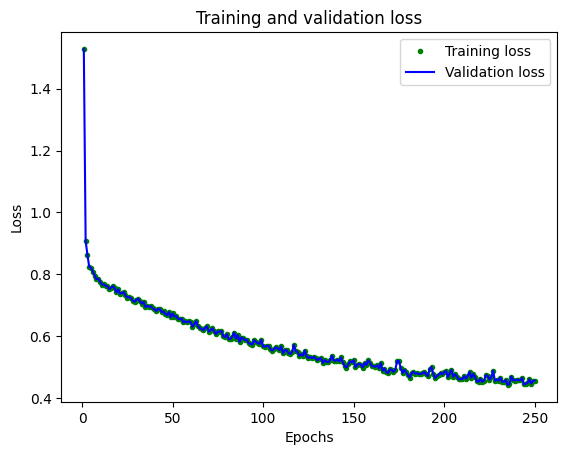

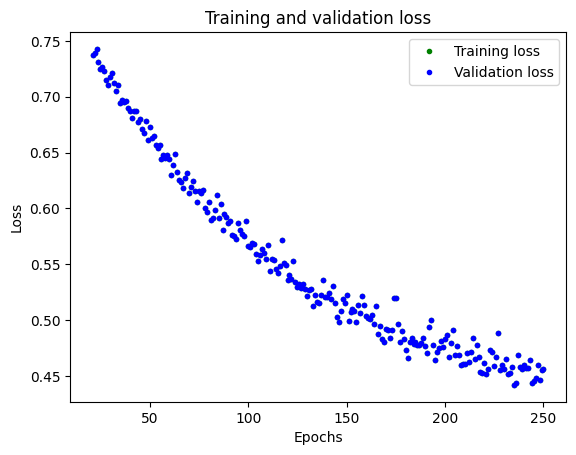

In [93]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
import matplotlib.pyplot as plt
train_loss = history_1.history['mae']
val_loss = history_1.history['mae']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 20

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [94]:
housePrices_model.save('test')
reloaded = tf.keras.models.load_model('test')

features_dict = {name:values[:1] for name, values in housePrices_features_dict.items()}

before = housePrices_model(features_dict)
after = reloaded(features_dict)
assert (before-after)<1e-3
print(before)
print(after)

INFO:tensorflow:Assets written to: test/assets


INFO:tensorflow:Assets written to: test/assets


tf.Tensor([[5.783]], shape=(1, 1), dtype=float32)
tf.Tensor([[5.783]], shape=(1, 1), dtype=float32)


In [95]:
houseData_own2 = {'Type': np.array(['SFH', 'SFH', 'SFH', 'Condo', 'Condo']),
  'houseEra': np.array(['recent', '19A', '20A', '20A', '19B']),
	'Area': np.array([8410, 1400, 1500, 1500, 1600]),
  'Zip': np.array(['60062', '60062', '60076', '60076', '60202']),
	'Rooms': np.array([16, 6, 7, 7, 7]),
  'FullBaths': np.array([6.0, 2.0, 2.0, 2.5, 2.0]),
  'HalfBaths': np.array([0.0, 1.0, 1.0, 0.0, 0.0]),
  'BsmtBth': np.array(['Yes', 'No', 'No', 'No', 'No']),
  'Beds': np.array([5, 3, 3, 3, 3]),
  'BsmtBeds': np.array([1.0, 0.0, 0.0, 0.0, 0.0]),
  'GarageSpaces': np.array([3, 2, 0, 0, 0])  }

ans = reloaded.predict(houseData_own2)

print(ans)

1/1 [==============================] - 0s 132ms/step
[[14.591]
 [ 4.224]
 [ 3.713]
 [ 1.87 ]
 [ 3.421]]
